### Import Dependences


In [128]:
import numpy as np
import pandas as pd
import matplotlib . pyplot as plt
from matplotlib.widgets import Slider

from sklearn . tree import DecisionTreeRegressor
from sklearn . ensemble import RandomForestRegressor
from sklearn . ensemble import AdaBoostRegressor
from sklearn . ensemble import GradientBoostingRegressor

from sklearn . preprocessing import OrdinalEncoder , StandardScaler
from sklearn . model_selection import train_test_split
from sklearn . metrics import mean_absolute_error , mean_squared_error, accuracy_score
from sklearn.datasets import make_regression

### AdaBoost Algorithm Building 

mse: 0.10809357318253665


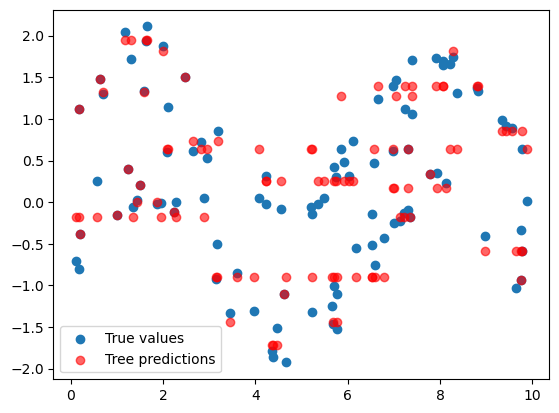

In [215]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        """
        feature: significant index to split branch
        threshold: threshold to device branch
        left: left branch of Tree
        right: right branch of Tree
        value: value 
        
        """
        self.feature = feature      
        self.threshold = threshold  
        self.left = left    
        self.right = right  
        self.value = value  

# Cây quyết định hồi quy hỗ trợ nhiều features
class DecisionTreeRegressorCus:
    def __init__(self, max_depth=None, min_samples_split=2):
        """"""
        self.max_depth = max_depth  # Độ sâu tối đa của cây
        self.min_samples_split = min_samples_split  # Số mẫu tối thiểu để chia tiếp
        self.root = None  # Gốc của cây quyết định

    # Hàm huấn luyện với hỗ trợ sample weights
    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            sample_weight = np.ones(len(y))  # Nếu không có trọng số, mặc định bằng 1
        self.root = self._grow_tree(X, y, sample_weight, depth=0)

    # Hàm dự đoán
    def predict(self, X):
        return np.array([self._predict(inputs, self.root) for inputs in X])

    # Hàm xây dựng cây quyết định
    def _grow_tree(self, X, y, sample_weight, depth):
        n_samples, n_features = X.shape
        # Dừng nếu đạt điều kiện độ sâu tối đa hoặc số mẫu nhỏ hơn ngưỡng
        if (self.max_depth is not None and depth >= self.max_depth) or n_samples < self.min_samples_split:
            return DecisionTreeNode(value=np.average(y, weights=sample_weight))

        # Tìm cách chia tốt nhất
        best_feature, best_threshold = self._best_split(X, y, sample_weight, n_features)
        if best_feature is None:
            return DecisionTreeNode(value=np.average(y, weights=sample_weight))

        # Chia dữ liệu thành hai nhánh
        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold
        left = self._grow_tree(X[left_indices], y[left_indices], sample_weight[left_indices], depth + 1)
        right = self._grow_tree(X[right_indices], y[right_indices], sample_weight[right_indices], depth + 1)
        return DecisionTreeNode(feature=best_feature, threshold=best_threshold, left=left, right=right)

    # Hàm tìm cách chia tốt nhất dựa trên sample weights
    def _best_split(self, X, y, sample_weight, n_features):
        best_mse = float('inf')
        best_feature, best_threshold = None, None
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                mse = self._calculate_weighted_mse(X[:, feature], y, sample_weight, threshold)
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    # Hàm tính MSE có trọng số (weighted MSE) của một lần chia
    def _calculate_weighted_mse(self, feature_column, y, sample_weight, threshold):
        left_indices = feature_column < threshold
        right_indices = feature_column >= threshold
        if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
            return float('inf')
        y_left, y_right = y[left_indices], y[right_indices]
        weight_left, weight_right = sample_weight[left_indices], sample_weight[right_indices]
        mse_left = np.average((y_left - np.average(y_left, weights=weight_left)) ** 2, weights=weight_left)
        mse_right = np.average((y_right - np.average(y_right, weights=weight_right)) ** 2, weights=weight_right)
        mse = (np.sum(weight_left) * mse_left + np.sum(weight_right) * mse_right) / np.sum(sample_weight)
        return mse

    # Hàm dự đoán cho từng mẫu
    def _predict(self, inputs, node):
        if node.value is not None:
            return node.value
        if inputs[node.feature] < node.threshold:
            return self._predict(inputs, node.left)
        else:
            return self._predict(inputs, node.right)

# Tạo dữ liệu mẫu với 2 features
np.random.seed(0)
X = np.random.rand(100, 2) * 10  # 100 mẫu, mỗi mẫu có 2 feature
y = np.sin(X[:, 0]) + np.cos(X[:, 1]) + np.random.normal(0, 0.1, 100)

# Trọng số mẫu
sample_weights = np.ones(len(y))  # Ví dụ: tất cả trọng số mẫu đều bằng 1

# Huấn luyện DecisionTreeRegressor từ đầu có sử dụng sample weights
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X, y, sample_weight=sample_weights)

# Dự đoán
y_pred = tree.predict(X)

# Vẽ đồ thị kết quả (Chỉ vẽ với một feature để hình dung)
print(f'mse: {mean_squared_error(y, y_pred)}')
plt.scatter(X[:, 0], y, label='True values')
plt.scatter(X[:, 0], y_pred, color='red', label='Tree predictions', alpha=0.6)
plt.legend()
plt.show()

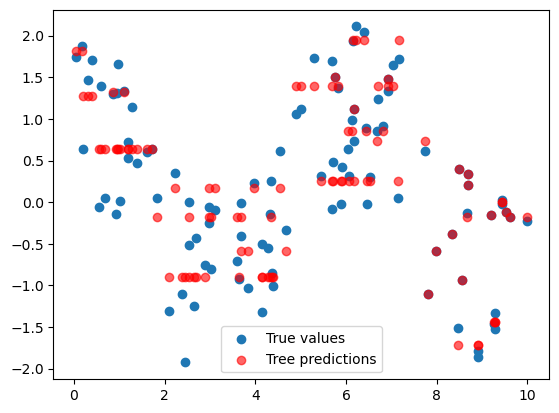

In [217]:
plt.scatter(X[:, 1], y, label='True values')
plt.scatter(X[:, 1], y_pred, color='red', label='Tree predictions', alpha=0.6)
plt.legend()
plt.show()

mean squared error: 0.2732255472632371


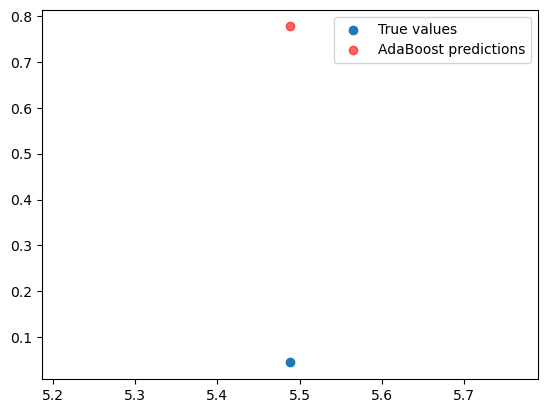

In [229]:
class AdaBoostRegressorCus:
    def __init__(self, n_estimators=50, learning_rate=1.0, max_depth = 1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimators = []
        self.estimator_weights = []
        self.max_depth = max_depth
        
    def fit(self, X, y):
        n_samples = X.shape[0]
        # Trọng số của mỗi điểm dữ liệu
        weights = np.ones(n_samples) / n_samples
        for _ in range(self.n_estimators):
            # Tạo một cây quyết định đơn giản (Decision Stump)
            estimator = DecisionTreeRegressorCus(max_depth=self.max_depth)
            estimator.fit(X, y, sample_weight=weights)
            y_pred = estimator.predict(X)
            
            # Tính lỗi của cây quyết định
            error = np.sum(weights * np.abs(y_pred - y)) / np.sum(weights)
            
            # Nếu lỗi quá lớn, bỏ qua estimator này
            if error >= 0.5:
                continue
            
            # Tính trọng số cho cây quyết định
            estimator_weight = self.learning_rate * 0.5 * np.log((1 - error) / error)
            
            # Cập nhật trọng số cho các mẫu
            weights *= np.exp(estimator_weight * np.abs(y_pred - y))
            weights /= np.sum(weights)
            
            # Lưu lại cây quyết định và trọng số của nó
            self.estimators.append(estimator)
            self.estimator_weights.append(estimator_weight)
    
    def predict(self, X):
        # Dự đoán dựa trên các cây quyết định với trọng số
        final_prediction = np.zeros(X.shape[0])
        for estimator, weight in zip(self.estimators, self.estimator_weights):
            final_prediction += weight * estimator.predict(X)
        return final_prediction / np.sum(self.estimator_weights)

# Tạo dữ liệu mẫu với 2 features
np.random.seed(0)
X = np.random.rand(100, 2) * 10  # 100 mẫu, mỗi mẫu có 2 features
y = np.sin(X[:, 0]) + np.cos(X[:, 1]) + np.random.normal(0, 0.1, 100)

# Huấn luyện AdaBoost với các cây quyết định
adaboost = AdaBoostRegressorCus(n_estimators=50, learning_rate=0.1,max_depth= 3)
adaboost.fit(X, y)

# Dự đoán
y_pred = adaboost.predict(X)
print(f'mean squared error: {mean_squared_error(y, y_pred)}')
# Vẽ đồ thị kết quả
plt.scatter(X[:, 0][0], y[0], label='True values')
plt.scatter(X[:, 0][0], y_pred[0], color='red', label='AdaBoost predictions', alpha=0.6)
plt.legend()
plt.show()

### Data 

#### Data Preparing

In [192]:
np.random.seed(42)
X = np.random.rand(100, 2) * 10  # 100 data point with vi 2 features in range [0, 10]
y = 3 * X[:, 0] + 2 * X[:, 1] + np.random.randn(100) * 2  # additionally, little noise
print(X.shape)
print(X[1])
print(y[0])

(100, 2)
[7.31993942 5.98658484]
28.890440250462213


#### Data Visualization 

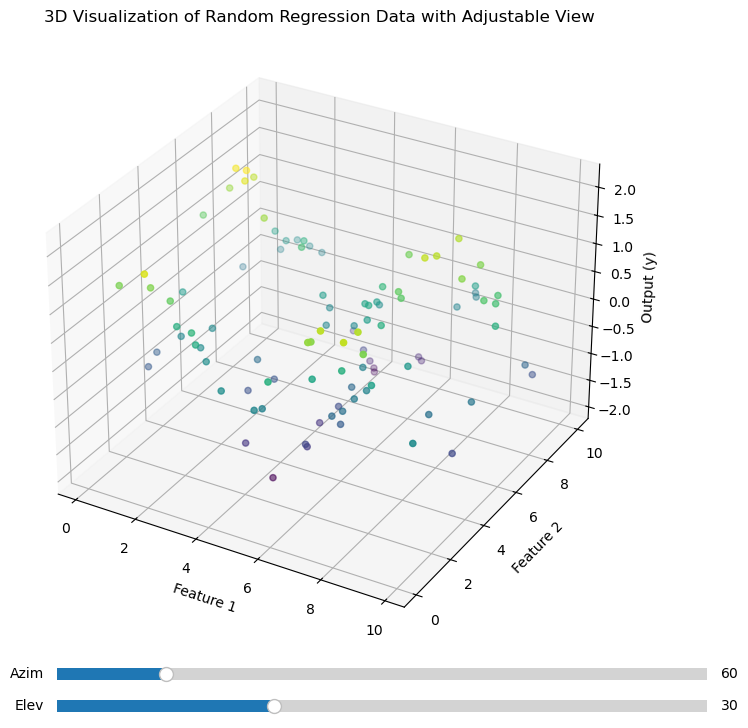

In [230]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X[:, 0], X[:, 1], y, c=y, cmap='viridis', marker='o')

ax.set_title('3D Visualization of Random Regression Data with Adjustable View')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Output (y)')

axcolor = 'lightgoldenrodyellow'
ax_elev = plt.axes([0.25, 0.02, 0.65, 0.03], facecolor=axcolor)  # Slider cho elev
ax_azim = plt.axes([0.25, 0.06, 0.65, 0.03], facecolor=axcolor)  # Slider cho azim

slider_elev = Slider(ax_elev, 'Elev', 0, 90, valinit=30)
slider_azim = Slider(ax_azim, 'Azim', 0, 360, valinit=60)

def update(val):
    ax.view_init(elev=slider_elev.val, azim=slider_azim.val)
    fig.canvas.draw_idle()  # Cập nhật lại figure

slider_elev.on_changed(update)
slider_azim.on_changed(update)

plt.show()

### Training, Inference and Evaluation

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')
print(f'X_train[0]: {X_train[0]}')
print(f'X_test[0]: {X_test[0]}')
print(f'y_train[0]: {y_train[0]}')
print(f'y_test[0]: {y_test[0]}')

X_train: (70, 2)
X_test: (30, 2)
y_train: (70,)
y_test: (30,)
X_train[0]: [4.61479362 7.80529176]
X_test[0]: [0.11714084 3.59978064]
y_train[0]: -1.1010478264768926
y_test[0]: -0.7122915354800268


#### Inference on the customize class

In [232]:
adaboost = AdaBoostRegressorCus(n_estimators=20, learning_rate=1, max_depth=3)
adaboost.fit(X, y)

y_pred = adaboost.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(y_pred)

print(y_pred)

Mean Squared Error: 0.2246
[-0.51779508  0.7787003  -0.51779508  0.7787003  -1.51093285  0.91128853
  0.7787003  -0.51779508 -0.29073038  0.7787003   0.7787003   0.91128853
 -0.26568536  0.91128853  1.69562546 -0.51779508  1.69562546  0.10112278
  1.69562546  0.91128853 -1.51093285 -1.51093285  0.91128853 -0.51779508
 -0.51779508  0.7787003  -0.51779508  0.10112278 -0.29073038  0.7787003 ]
[-0.51779508  0.7787003  -0.51779508  0.7787003  -1.51093285  0.91128853
  0.7787003  -0.51779508 -0.29073038  0.7787003   0.7787003   0.91128853
 -0.26568536  0.91128853  1.69562546 -0.51779508  1.69562546  0.10112278
  1.69562546  0.91128853 -1.51093285 -1.51093285  0.91128853 -0.51779508
 -0.51779508  0.7787003  -0.51779508  0.10112278 -0.29073038  0.7787003 ]


#### Inference on the 

In [234]:
adaboost = AdaBoostRegressor(n_estimators=50,max_depth=3, learning_rate=0.1)
adaboost.fit(X_train, y_train)

y_pred = adaboost.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(y_test)
print(y_pred)


Mean Squared Error: 0.9809
[-0.71229154  0.48222441 -0.40178261  0.85653897 -1.52834831  0.5362488
  1.24130776  0.6107955  -0.59078095  0.04457804  0.7285849   1.33963273
 -0.15477485  1.65608091  2.10999705 -1.02951809  1.93612049  0.40081327
  2.03772752  0.46952264 -1.51229928 -1.32744673  0.01560587 -1.24582061
 -0.1458267   0.61922923 -0.50047993 -0.02770615  0.33308836  1.64651419]
[ 0.38286988 -0.41189193  0.76402818 -0.41189193 -1.55158906  1.26271979
 -0.41189193 -0.41189193  0.76402818 -0.41189193 -0.41189193  1.26271979
  0.38286988  1.52439699  0.38286988  0.76402818  0.38286988  0.38286988
  0.38286988 -0.41189193 -1.55158906 -1.55158906  1.52439699 -0.41189193
 -0.41189193  0.38286988 -0.41189193  0.38286988 -0.17778851  0.76402818]


In [242]:
mse = mean_squared_error(y_test, y_pred)
print(f"mse: {mse:.2f}")

mse: 0.98


#### Inference on the standard library


In [137]:
print(y_train[0])
print(X_train[0])

14.450211685226957
[2.92144649 3.66361843]


In [243]:
model = AdaBoostRegressor(n_estimators=50,learning_rate=1,max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f'y_pred: {y_pred}')
print(f'y: {y_test}')

y_pred: [ 0.38393097 -0.41240856  0.76365938 -0.41240856 -1.55146761  1.26287395
 -0.41240856 -0.41240856  0.76365938 -0.41240856 -0.41240856  1.26287395
  0.38393097  1.52441799  0.38393097  0.76365938  0.38393097  0.38393097
  0.38393097 -0.41240856 -1.55146761 -1.55146761  1.52441799 -0.41240856
 -0.41240856  0.38393097 -0.41240856  0.38393097 -0.17778849  0.76365938]
y: [-0.71229154  0.48222441 -0.40178261  0.85653897 -1.52834831  0.5362488
  1.24130776  0.6107955  -0.59078095  0.04457804  0.7285849   1.33963273
 -0.15477485  1.65608091  2.10999705 -1.02951809  1.93612049  0.40081327
  2.03772752  0.46952264 -1.51229928 -1.32744673  0.01560587 -1.24582061
 -0.1458267   0.61922923 -0.50047993 -0.02770615  0.33308836  1.64651419]


In [244]:
accuracy = mean_squared_error(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


### Mean and mse

In [81]:
a = np.array([12,20,28])
print(f'mean: {a.mean()}')
mse = np.sum((a-a.mean())**2)
print(f'mse: {mse}')

mean: 20.0
mse: 128.0
